In [1]:
#!pip install --upgrade oct2py
import numpy as np
from oct2py import octave
import matplotlib.pyplot as plt
import os
from scipy.optimize import root
import pickle

`DyPy` is a class that we create and store in a file called `MyPy.py`. It contains methods for 

* converting data from a Dynare stucture to Numpy arrays.
* analyzing the data. 

See the file for details. 

In [2]:
from MyPy import DyPy

Creates a file called `t_call.m`. This informs Dynare of the format we want for output. It is put here so that adjusments can be made easily; for example the number of periods can be changed here rather than by looking at the `.mod` file. It is included in the `.mod` file via: `@#include "t_call.m"` in `model_1.mod`

* `order`: the order of approximation for the stochastic simulation. order=1 is a fsrst-order approximation (linearization) Higher-order approximations (e.g., order=2 for second-order) capture nonlinear effects in the model, but they require more computational resources.
* `periods`: number of periods (time steps) for which the simulation will be run. periods=1000 means that the model will be simulated for 1000 periods. The default value is 0, which means no simulation will be performed.
* `nograph`: suppresses the graphical output of the simulation results in Dynare since we draw them separatetly. 
* `irf`: the number of periods for which the impulse response functions (IRFs) will be computed and plotted. 

In [3]:
with open('t_call.m', 'w') as file:
    file.write("stoch_simul(nograph, order=1, periods=1000, irf=100);")

 `make_model.ipyn` writes a file called `t_model.m`. `t_model.m`is the `model` block in the Dynare `.mod` file. It can instead be created directlty by commenting out the next `%run` line and coding the model. `make_model.ipyn` simplifies model creation when many of the lines are very similar to each other. Then they can be written in for loops. For the model we are currently working with, there is not much advantage to writing the file via `make_model` but I have done so nonetheless. 
 
 The created file is included in the `.mod` file via `@#include "t_model.m"` in `model_1.mod`. 

In [4]:
%run make_model_3.ipynb

`make_files.ipynb` writes the other Dynare blocks. See that file for details. However, note that in doing so, it solves for the steady state of the model using `root` from `scipy`. If the results below do not indicate success, the `.mod` file may not run correctly. Also, note that though we solve for the steady state here, we do not give Dynare the steady state but rather use these as starting values for their ss solver. I will later code a verification the steady states are the same. 

In [5]:
%run make_files_1.ipynb

eps,tht,alf,bet,om_0,om_1,om_2,delt,psi_n,psi_k,var_a_0,var_a_1,var_a_2,rho_a_0,rho_a_1,rho_a_2


Tells octave where to find the .m file it will run. The file is `call_dynare`. Set to wherever you have this file. 




In [6]:
#a=octave.addpath(os.path.expanduser('C:/Users/blankenw/GitHub/dynare_progs/np_1'))

Makes a call to Octave, which makes a call to Dynare. Then the `.mod` file is run in Dynare. Output from Dynare is displayed as it runs.

In [7]:

# A list of dictionaries representing updates to apply to my_dict:
new_pars = [{'psi_n': 0, 'psi_k': 0}, 
           {'psi_n': 0, 'psi_k': 0}, 
           {'psi_n': 0, 'psi_k': 0}]

# Create an empty dictionary to store your variables
t=[]
with open('mf1.pkl', 'wb') as f:
    pickle.dump((ss_params,model_params,ss_shock), f)


for i, update in enumerate(new_pars):
    model_params.update(update)
    with open('mf1.pkl', 'wb') as f:
        pickle.dump((ss_params,model_params,ss_shock), f)
    %run make_files_2.ipynb
    with open('mf2.pkl', 'rb') as f:
        ss_dict = pickle.load(f)
    #from MyPy import DyPy
    y=1
    x=octave.call_dynare(y,nout=1)
    oo = octave.pull('oo_') 
    instance = DyPy(oo,ss_dict)
    
    t.append(instance)


 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00  0.000e+00 ...  9.045e-13  4.551e-13]
       x: [ 4.368e-01  2.816e-01 ...  8.740e-01  4.816e-01]
    nfev: 41
    fjac: [[-5.557e-02 -7.601e-11 ... -3.093e-03 -3.093e-03]
           [-4.443e-02  4.706e-11 ...  5.530e-02  1.915e-03]
           ...
           [-4.088e-01 -3.249e-01 ... -2.788e-01 -2.788e-01]
           [ 6.512e-02 -6.038e-02 ...  1.835e-03  1.835e-03]]
       r: [-1.800e+01  1.709e+00 ...  6.141e-01  1.483e-01]
     qtf: [-4.674e-11 -2.167e-12 ...  1.126e-14  1.562e-13]
    call_dynare at line 4 column 4
    _pyeval at line 57 column 30

    call_dynare at line 4 column 4
    _pyeval at line 57 column 30

Starting Dynare (version 6.1).
Calling Dynare with arguments: none
Starting preprocessing of the model file ...
Found 17 equation(s).
Evaluating expressions...
Computing static model derivatives (order 1).
Normalizing the static model...
Finding the optimal block decomposition of the sta

Dynare creates a `structure` which we will need so we `pull` it.

The output from Dynare is stored in a file called `oo_`. This brings `oo_` in as `oo`.

Draw all impulse response functions. 

In [8]:
def plot_dta(instances, attributes,periods=100):
    plt.figure(figsize=(15, 5))
    for j, attribute in enumerate(attributes):
        # Create a subplot for this attribute
        plt.subplot(1, len(attributes), j+1)
        for i, instance in enumerate(instances):
            # Get the attribute value (time series data)
            attr_value = getattr(instance.ir_level, attribute)
            attr_value = attr_value.reshape(-1, 1)
            length = attr_value.shape[0]
            tm = np.linspace(1, length, length)
            # Add a line to the plot for this time series
            plt.plot(tm[0:periods], attr_value[0:periods], label=labels[i])

        plt.title(attribute)
        plt.legend()

    # Show the figure with all subplots


In [9]:
n00=[]
s00=[]
for instance in t:
    n00.append(instance.ir_level.n_0_a_0)
    s00.append(instance.ir_level.s_0_a_0)
    

In [10]:
n0=t[1].ir_level.n_0_a_0
s0=t[1].ir_level.s_0_a_0
c0=t[1].ir_level.c_0_a_0
newstuff=n0/s0
t[1].ir_level.nstuff=newstuff


In [11]:
for instance in t:
    #loop through the instances and create an attribute for each
    instance.ir_level.ns0_a0 = instance.ir_level.n_0_a_0/instance.ir_level.s_0_a_0
    instance.ir_level.ns1_a0 = instance.ir_level.n_1_a_0/instance.ir_level.s_1_a_0
    instance.ir_level.ns2_a0 = instance.ir_level.n_2_a_0/instance.ir_level.s_2_a_0
    
    instance.ir_level.ns0_a1 = instance.ir_level.n_0_a_1/instance.ir_level.s_0_a_1
    instance.ir_level.ns1_a1 = instance.ir_level.n_1_a_1/instance.ir_level.s_1_a_1
    instance.ir_level.ns2_a1 = instance.ir_level.n_2_a_1/instance.ir_level.s_2_a_1
    
    instance.ir_level.kn0_a1 = instance.ir_level.k_0_a_1/instance.ir_level.n_0_a_1
    instance.ir_level.kn1_a1 = instance.ir_level.k_1_a_1/instance.ir_level.n_1_a_1
    instance.ir_level.kn2_a1 = instance.ir_level.k_2_a_1/instance.ir_level.n_2_a_1
    
    

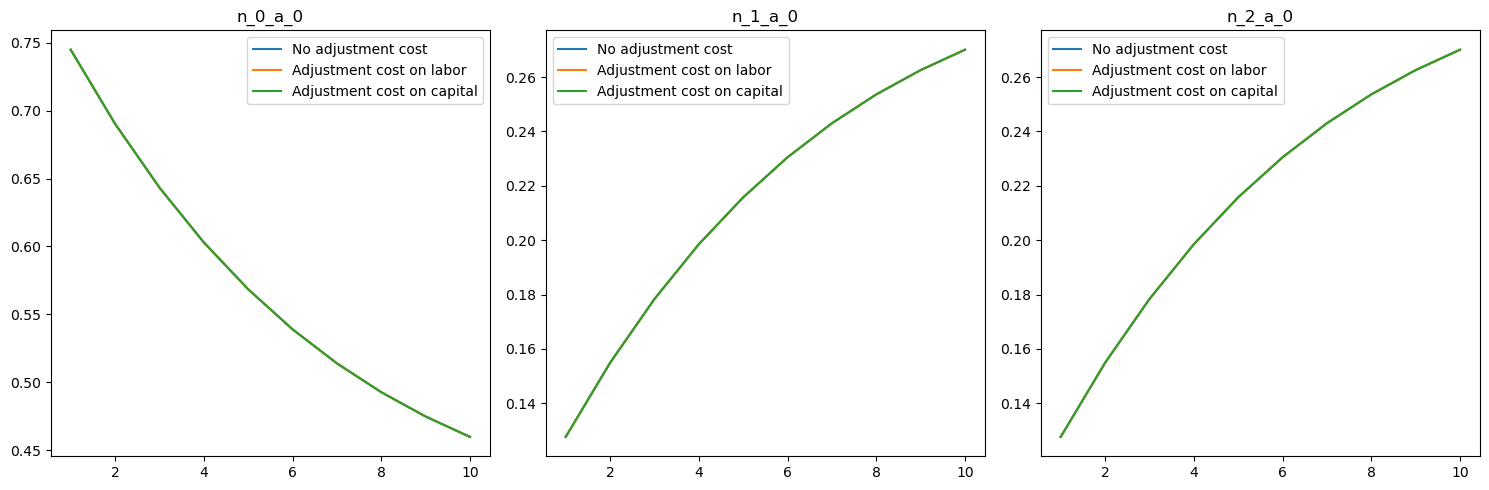

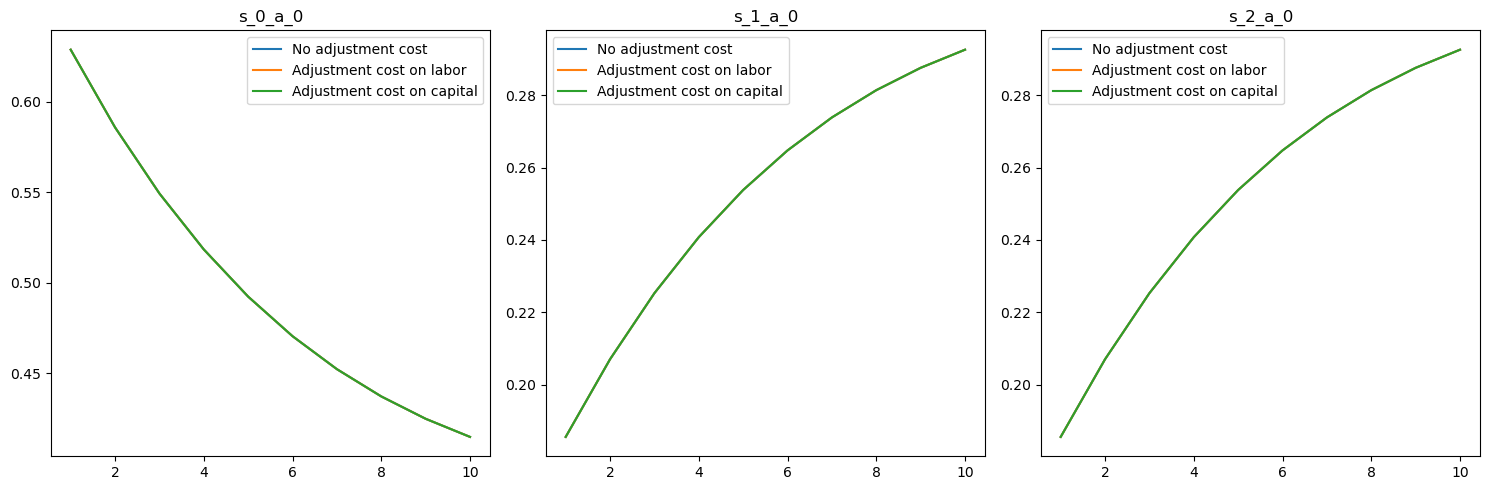

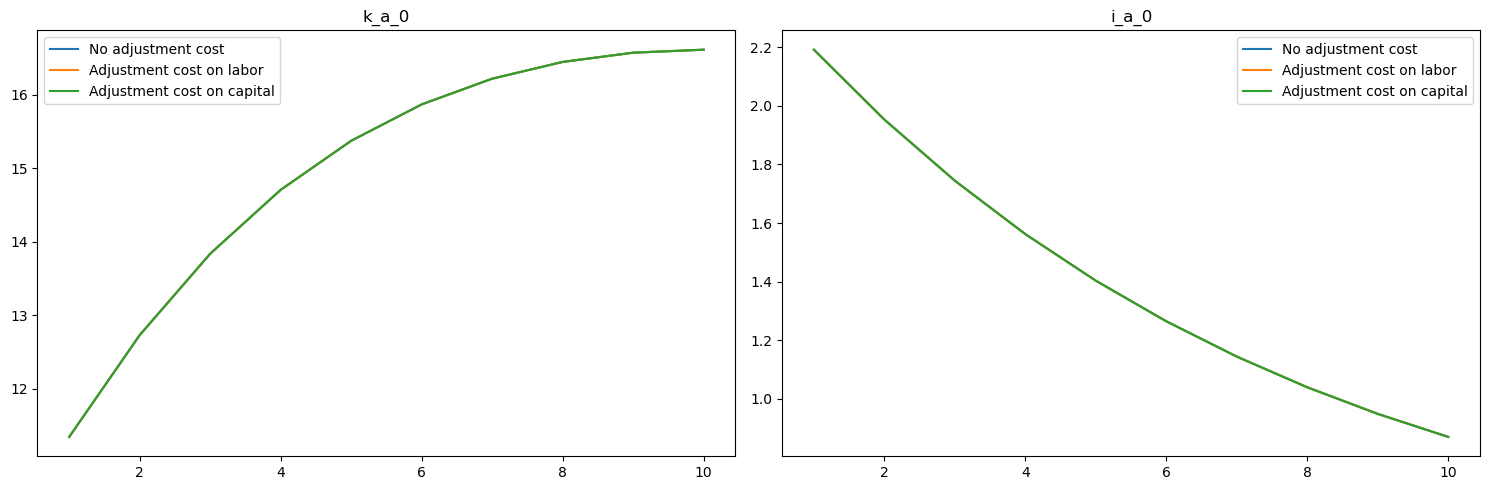

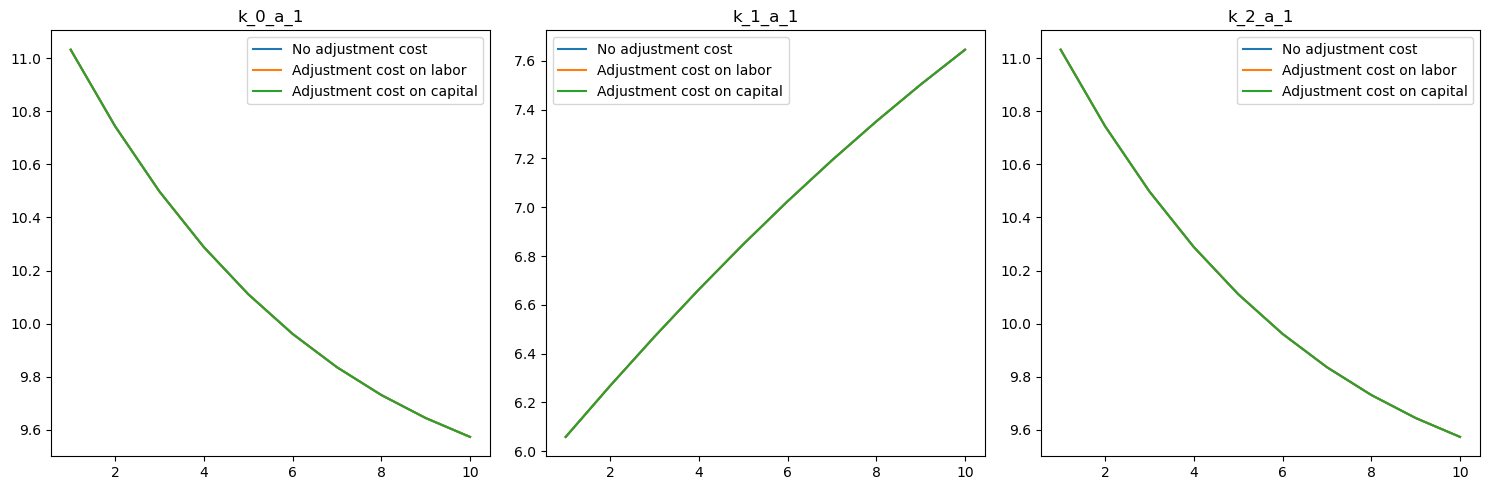

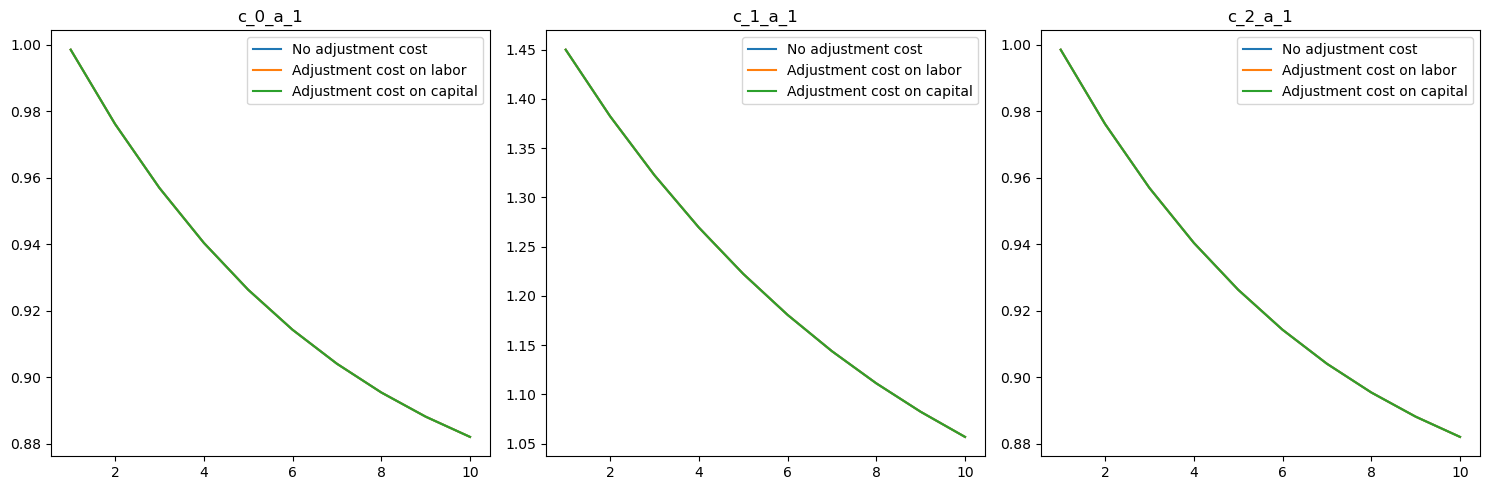

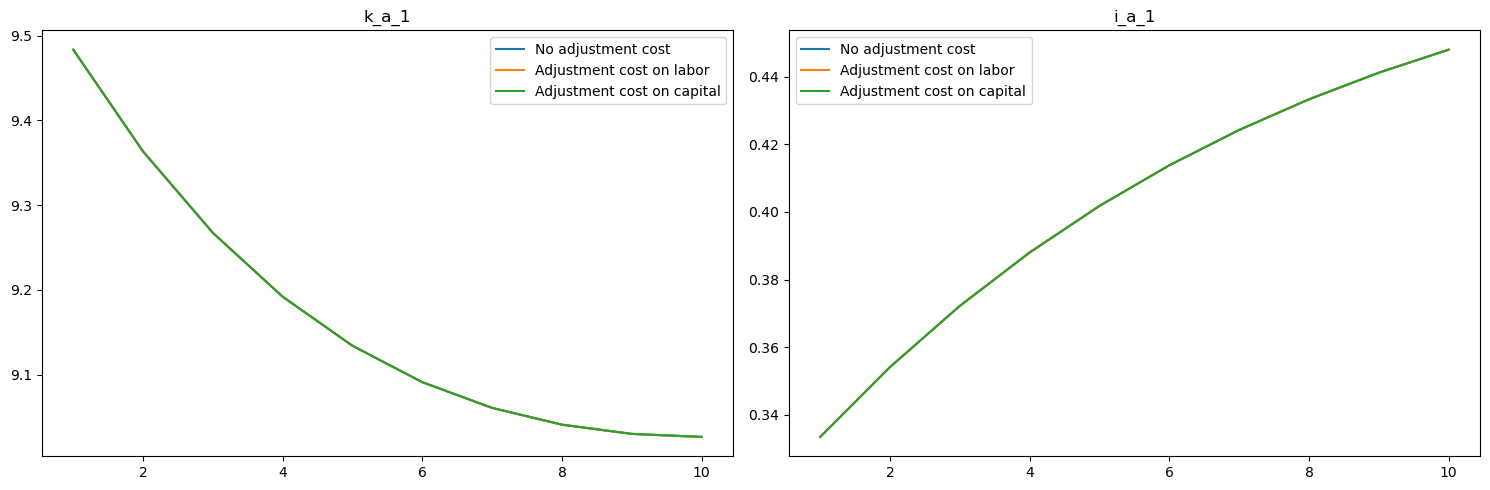

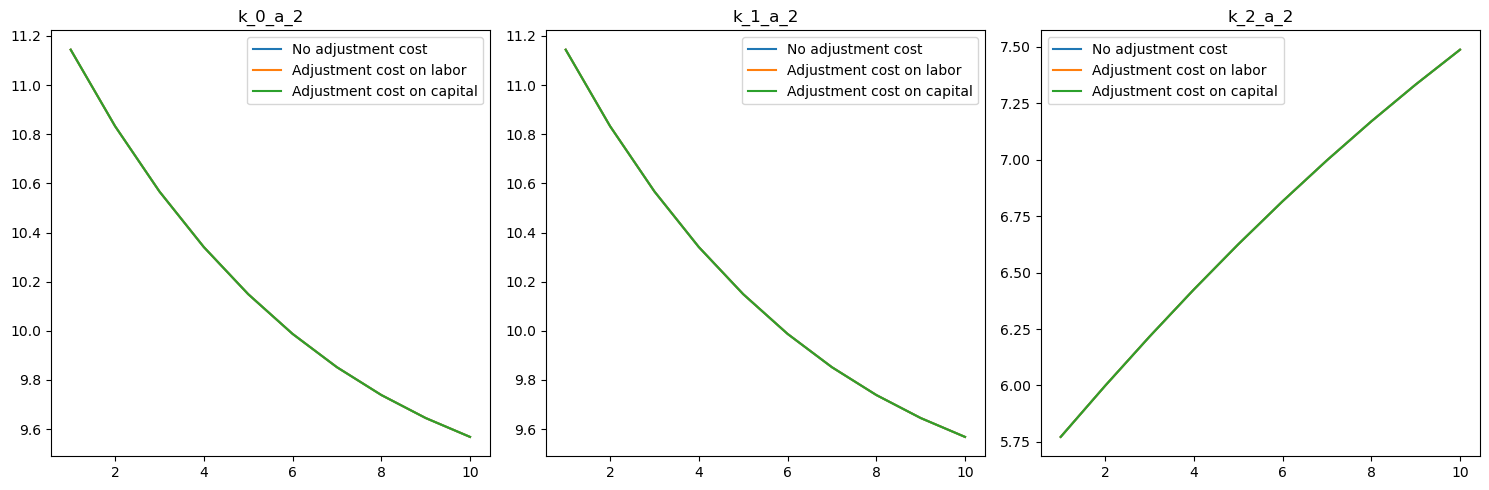

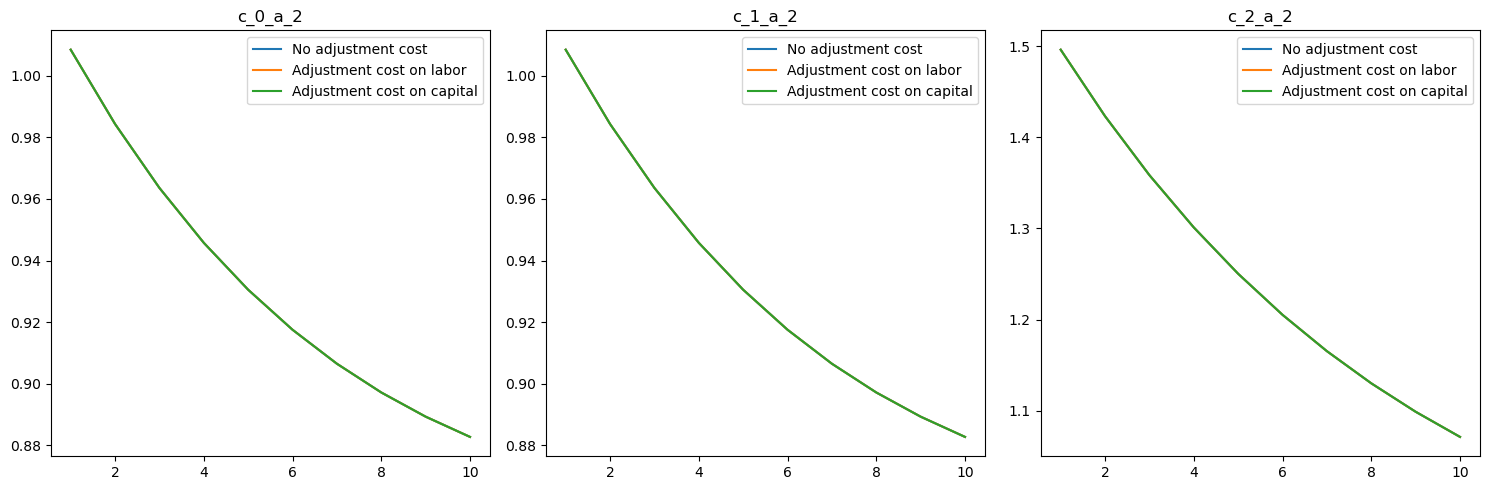

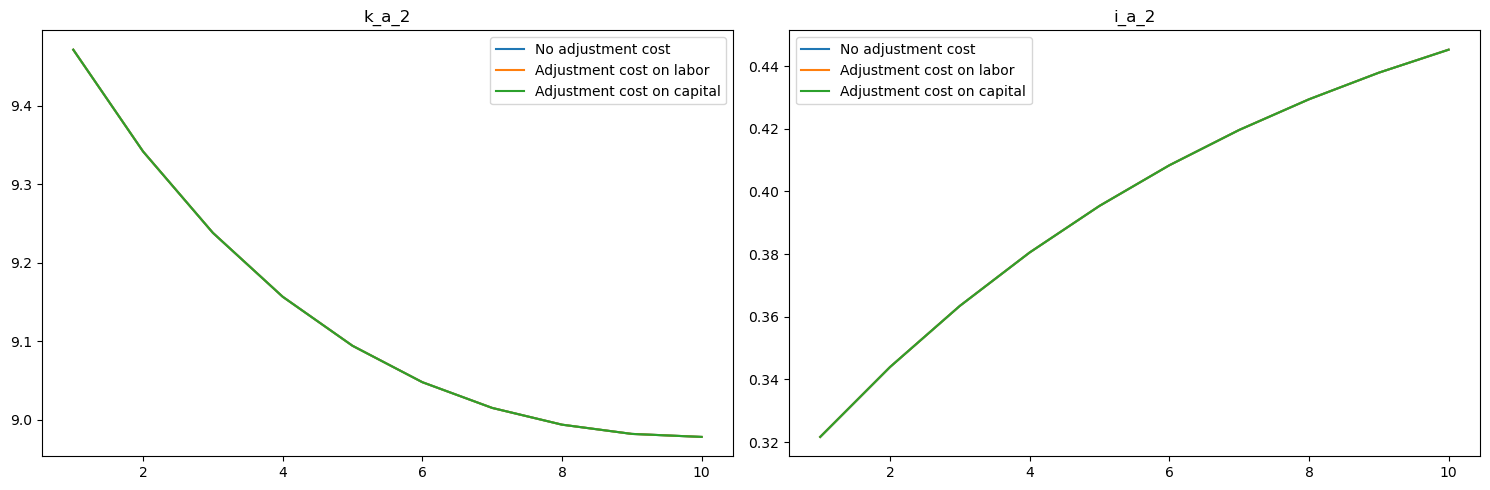

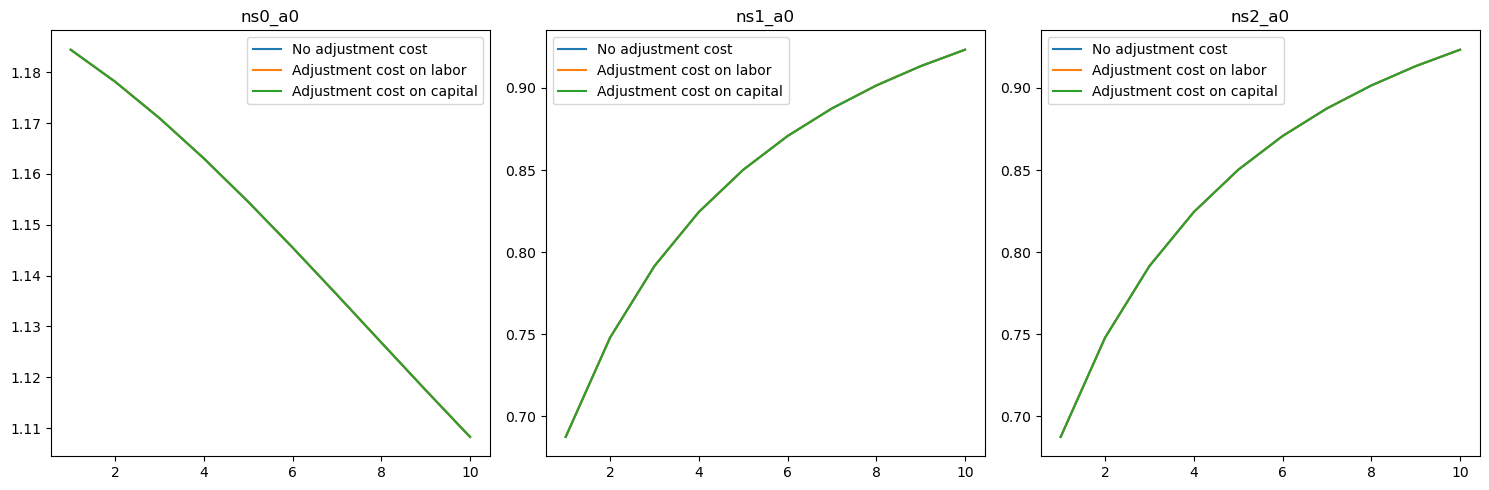

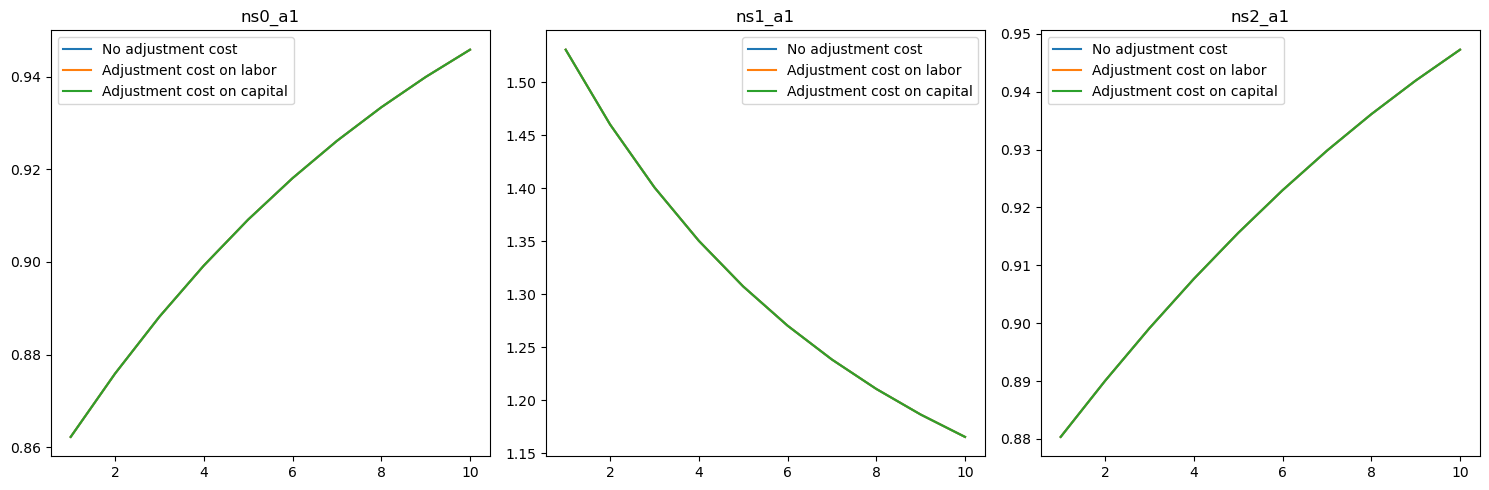

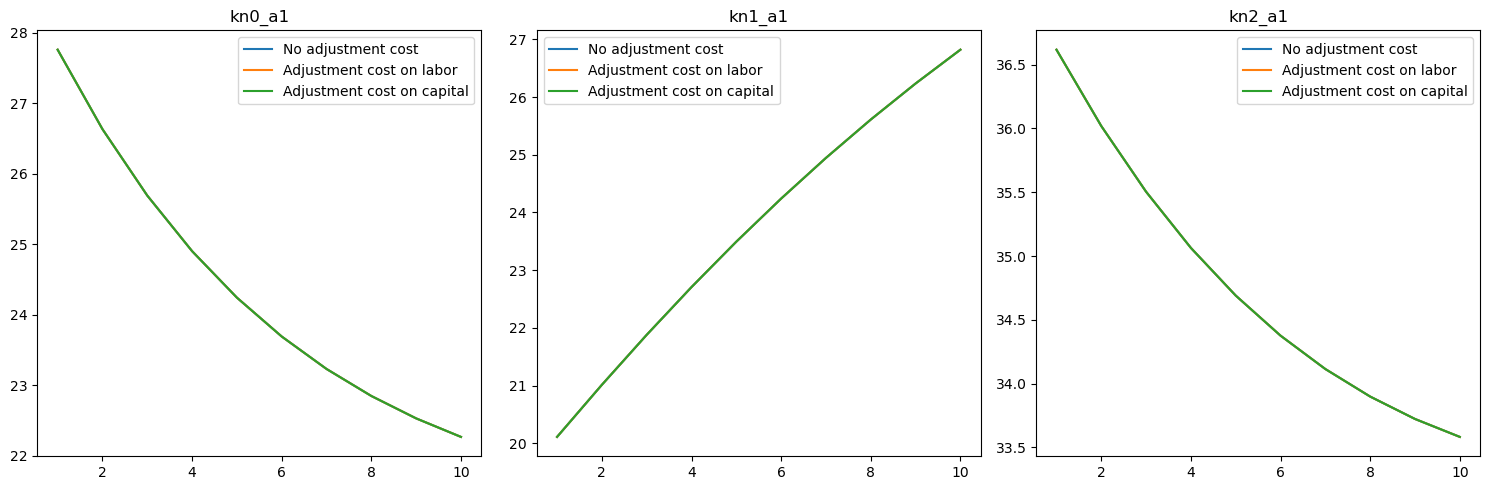

In [12]:
labels = ['No adjustment cost', 'Adjustment cost on labor', 'Adjustment cost on capital']

all_attributes =[['n_0_a_0', 'n_1_a_0', 'n_2_a_0'],
                 ['s_0_a_0', 's_1_a_0', 's_2_a_0'],
                 ['k_a_0', 'i_a_0'],
                    ['k_0_a_1', 'k_1_a_1', 'k_2_a_1'],
                    ['c_0_a_1', 'c_1_a_1', 'c_2_a_1'],
                    ['k_a_1', 'i_a_1'],
                    ['k_0_a_2', 'k_1_a_2', 'k_2_a_2'],
                    ['c_0_a_2', 'c_1_a_2', 'c_2_a_2'],
                    ['k_a_2', 'i_a_2'],
                    ['ns0_a0', 'ns1_a0', 'ns2_a0'],
                    ['ns0_a1', 'ns1_a1', 'ns2_a1'],
                    ['kn0_a1', 'kn1_a1', 'kn2_a1'],
                     ]
for attributes in all_attributes:
    plot_dta(t, attributes,periods=10)
    plt.tight_layout()
    plt.show()                  

